In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 운영체제에 따라 폰트 설정
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우 기본 한글 폰트
elif platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'  # 리눅스용 나눔폰트 설치 필요

# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 분석 아이디어
## 1. 고객 세분화 (Segmentation)
- **입력 변수**  
  - 페르소나 등급·점수, 연령대, 성별, 연소득 구간  
- **분석 방법**  
  - 군집 분석 (K-Means, 계층적 군집 등)  
- **출력 결과**  
  - 대표 고객 프로필(페르소나별 특징 요약)  
  - 세그먼트별 매출 및 구매 품목 패턴 비교  

## 2. 시간대별·요일별 매출 트렌드
- **변수 정의**  
  - `시간대_G2`, 매출 발생 요일, 휴일 여부  
- **분석 항목**  
  1. 피크 타임·비수기 파악 (시간대_G2 × 요일)  
  2. 휴일 여부와 매출 상관관계 분석  

## 3. 상품 카테고리 성과 분석
- **분류 체계**  
  - 대분류 / 중분류 / 소분류  
- **집계 지표**  
  - 매출금액, 구매 수량  
- **세부 분석**  
  - 특정 연령대·페르소나 세그먼트별 선호 제품군 도출  

## 4. 지역별 판매 전략 수립
- **지역 구분**  
  - 광역시·도 → 시·군·구 → 상권 유형  
- **분석 내용**  
  1. 상권별 매출 차이 분석  
  2. 상권 유형별 인기 상품 추천  

## 5. 고객 행동 예측 모델링
- **목표**  
  - ‘고액 결제 고객(상위 10%)’ 예측  
- **모델링 기법**  
  - 랜덤포레스트, 그라디언트 부스팅 등  
- **산출물**  
  - 모델 성능 지표(정확도, AUC 등)  
  - 핵심 피처 중요도 분석  

## 6. 장바구니 분석 (Association Rule Mining)
- **기법**  
  - Apriori, FP-Growth  
- **산출물**  
  - 동시 구매 패턴 규칙 (Support, Confidence, Lift)  
  - 교차 판매 및 추천 상품 구성  

## 7. 리텐션 및 재방문 분석
- **지표 정의**  
  - 월별 재구매율(고객 ID 기준)  
- **분석 내용**  
  1. 이탈 고객 특성 파악  
  2. 이탈 방지용 프로모션 타겟팅 전략  

## 8. 이상 거래 탐지
- **탐지 대상**  
  - 구매 수량, 매출 금액  
- **기법**  
  - 통계적 이상치 탐지 (IQR, Z-score)  
  - 머신러닝 기반 이상치 탐지  
- **추가 분석**  
  - 현금서비스 사용 여부 연계 리스크 분석  

## 9. 캠페인 효과 예측
- **목표**  
  - 특정 페르소나 그룹


In [17]:
df = pd.read_csv('data/card.csv', encoding='utf-8')

df.head()

,매출_일련번호,매출년월,시간대_G2,매출금액,연령대_10세,성별,추정라이프스테이지,추정직업군,추정연소득구간,페르소나_1인가구_등급,...,제품코드,제품코드명,제품금액,제품수량,제품대분류코드,제품대분류코드명,제품중분류코드,제품중분류코드명,제품소분류코드,제품소분류코드명
0,1,202007,18-24,87934,40대,M,자영업,무직,6000-8000,3,...,P49073,음료,18832,3,200,생활,220,의류,122,초콜릿
1,2,202103,12-18,7144,60대,M,은퇴,생산직,6000-8000,1,...,P22536,도시락,44521,1,300,서비스,120,스낵,111,콜라
2,3,202101,12-18,40354,30대,F,자영업,무직,2000-4000,4,...,P54034,생필품,2784,4,300,서비스,220,의류,121,과자
3,4,202011,18-24,46367,30대,F,직장인,전문의,2000-4000,3,...,P95320,스낵,15698,1,100,식음료,210,주택,122,초콜릿
4,5,202011,00-06,79990,50대,F,직장인,생산직,8000+,4,...,P71736,간식,38158,2,300,서비스,120,스낵,211,의류


In [11]:
df.columns

Index(['매출_일련번호', '매출년월', '시간대_G2', '매출금액', '연령대_10세', '성별', '추정라이프스테이지',
       '추정직업군', '추정연소득구간', '페르소나_1인가구_등급', '페르소나_1인가구_스코어', '페르소나_액티브시니어_등급',
       '페르소나_액티브시니어_스코어', '페르소나_반려동물보유_등급', '페르소나_반려동물보유_스코어', '페르소나_온라인쇼핑_등급',
       '페르소나_온라인쇼핑_스코어', '페르소나_건강관심_등급', '페르소나_건강관심_스코어', '페르소나_자녀교육관심_등급',
       '페르소나_자녀교육관심_스코어', '페르소나_문화활동관심_등급', '페르소나_문화활동관심_스코어',
       '페르소나_프리미엄소비_등급', '페르소나_프리미엄소비_스코어', '페르소나_가격민감_등급', '페르소나_가격민감_스코어',
       '페르소나_얼리어답터_등급', '페르소나_얼리어답터_스코어', '페르소나_아웃도어활동관심_등급',
       '페르소나_아웃도어활동관심_스코어', '페르소나_국내여행관심_등급', '페르소나_국내여행관심_스코어',
       '페르소나_해외여행관심_등급', '페르소나_해외여행관심_스코어', '페르소나_배달식선호_등급', '페르소나_배달식선호_스코어',
       '페르소나_간편식선호_등급', '페르소나_간편식선호_스코어', '페르소나_밀키트선호_등급', '페르소나_밀키트선호_스코어',
       '개인신용판매_이용금액_등급', '주점업종_이용금액_등급', '주류판매점업종_이용금액_등급',
       '제과아이스크림업종_이용금액_등급', '커피음료업종_이용금액_등급', '한식업종_이용금액_등급', '일식업종_이용금액_등급',
       '중식업종_이용금액_등급', '양식업종_이용금액_등급', '부페업종_이용금액_등급', '패스트푸드업종_이용금액_등급',
       '간이음식점업종_이용금액_등급', '할인점업종_이용금액_등급', '마트업종_이용금액_등급'


Missing values (top 10):
매출_일련번호            0.0
부페업종_이용금액_등급       0.0
배달앱업종_이용금액_등급      0.0
편의점업종_이용금액_등급      0.0
백화점업종_이용금액_등급      0.0
마트업종_이용금액_등급       0.0
할인점업종_이용금액_등급      0.0
간이음식점업종_이용금액_등급    0.0
패스트푸드업종_이용금액_등급    0.0
양식업종_이용금액_등급       0.0
dtype: float64


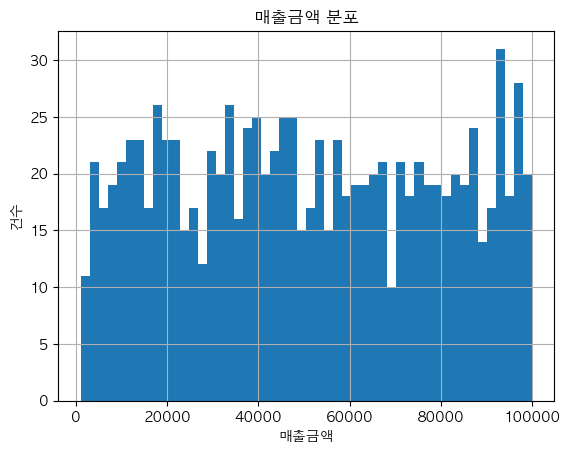

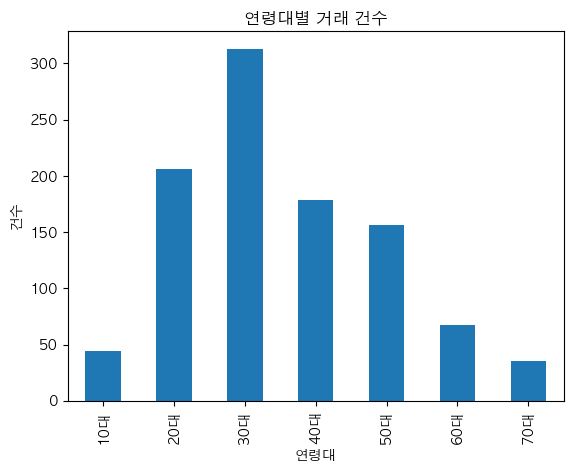

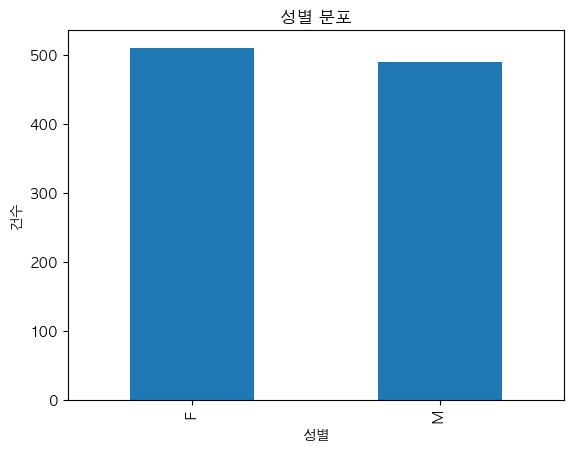

In [22]:
# 결측치 확인
missing = df.isnull().mean().sort_values(ascending=False)
print("\nMissing values (top 10):")
print(missing.head(10))

# 2. 기본 시각화
plt.figure()
df['매출금액'].hist(bins=50)
plt.title('매출금액 분포')
plt.xlabel('매출금액')
plt.ylabel('건수')
plt.show()

plt.figure()
df['연령대_10세'].value_counts().sort_index().plot(kind='bar')
plt.title('연령대별 거래 건수')
plt.xlabel('연령대')
plt.ylabel('건수')
plt.show()

plt.figure()
df['성별'].value_counts().plot(kind='bar')
plt.title('성별 분포')
plt.xlabel('성별')
plt.ylabel('건수')
plt.show()

In [26]:
# 3. 고객 세분화 (KMeans)
persona_cols = [c for c in df.columns if '페르소나_' in c and c.endswith('_스코어')]
X = df[persona_cols]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42)
df['segment'] = kmeans.fit_predict(X_scaled)

# 세그먼트별 매출금액 평균
seg_summary = df.groupby('segment')['매출금액'].mean()
print("\n세그먼트별 평균 매출금액:")
print(seg_summary)


세그먼트별 평균 매출금액:
segment
0    50417.163701
1    49216.960630
2    51096.538835
3    52737.104247
Name: 매출금액, dtype: float64


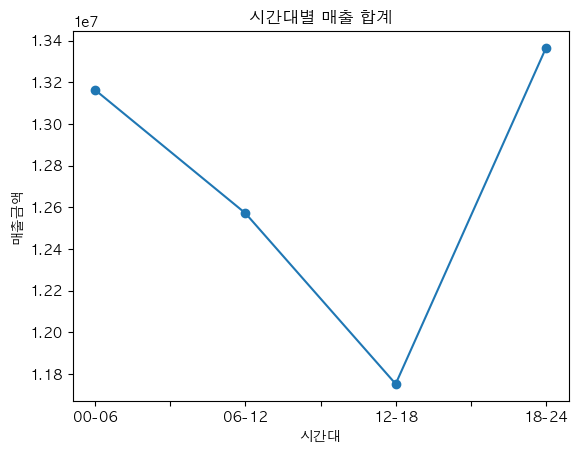

In [28]:
# 4. 시간대별 매출 트렌드
time_trend = df.groupby('시간대_G2')['매출금액'].sum().reindex(['00-06','06-12','12-18','18-24'])
plt.figure()
time_trend.plot(marker='o')
plt.title('시간대별 매출 합계')
plt.xlabel('시간대')
plt.ylabel('매출금액')
plt.show()

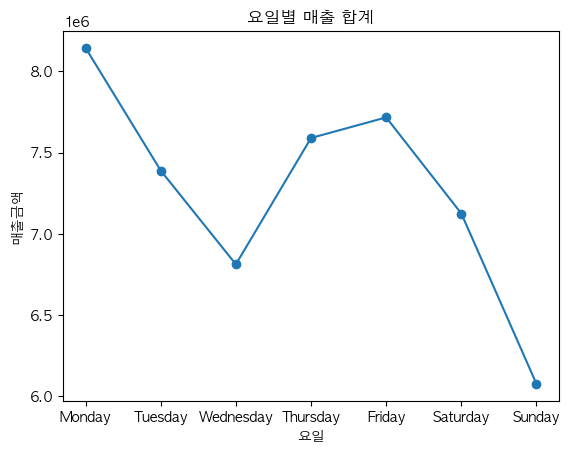

In [30]:
# 5. 요일별 매출 트렌드
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
weekday_trend = df.groupby('매출발생요일')['매출금액'].sum().reindex(weekday_order)
plt.figure()
weekday_trend.plot(marker='o')
plt.title('요일별 매출 합계')
plt.xlabel('요일')
plt.ylabel('매출금액')
plt.show()

제품대분류별 매출 합계 및 거래건수:
| 제품대분류코드명   |    매출합계 |   거래건수 |
|:-------------------|------------:|-----------:|
| 식음료             | 1.71114e+07 |        338 |
| 서비스             | 1.70485e+07 |        342 |
| 생활               | 1.66932e+07 |        320 |


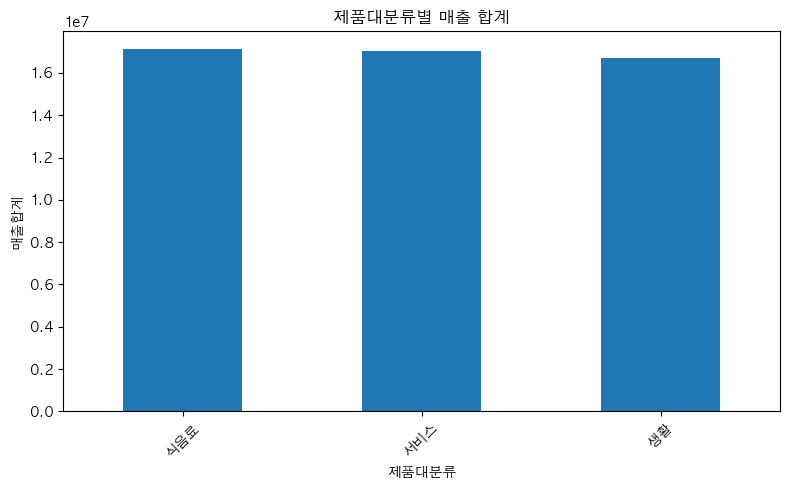

In [38]:

# 1) 상품 카테고리 성과 분석
cat_perf = (
    df.groupby('제품대분류코드명')['매출금액']
    .agg(매출합계='sum', 거래건수='count')
    .sort_values('매출합계', ascending=False)
)
print("제품대분류별 매출 합계 및 거래건수:")
print(cat_perf.to_markdown())

plt.figure(figsize=(8, 5))
cat_perf['매출합계'].plot.bar()
plt.title('제품대분류별 매출 합계')
plt.xlabel('제품대분류')
plt.ylabel('매출합계')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


이상 거래 탐지 요약:
|   전체거래건수 |   이상거래건수 |   이상거래비율 |
|---------------:|---------------:|---------------:|
|           1000 |              0 |              0 |


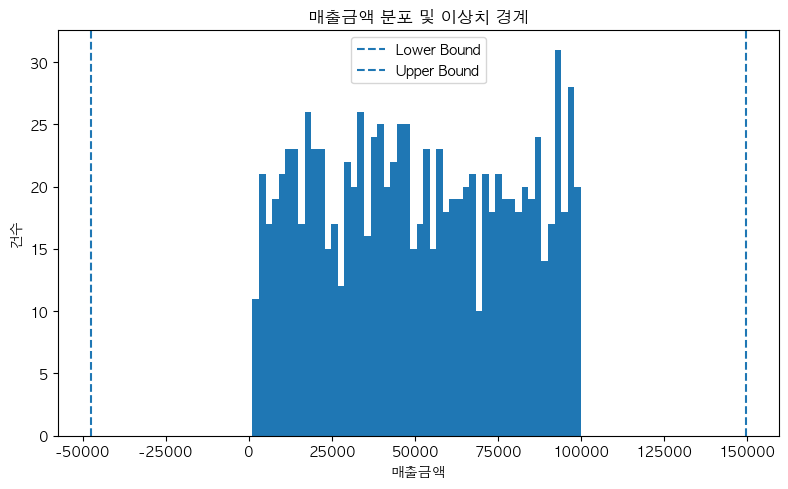

In [40]:
# 2) 이상 거래 탐지 (IQR 기반)
q1 = df['매출금액'].quantile(0.25)
q3 = df['매출금액'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

anomalies = df[(df['매출금액'] < lower_bound) | (df['매출금액'] > upper_bound)]
summary = pd.DataFrame({
    '전체거래건수': [len(df)],
    '이상거래건수': [len(anomalies)],
    '이상거래비율': [len(anomalies) / len(df)]
})
print("\n이상 거래 탐지 요약:")
print(summary.to_markdown(index=False))

plt.figure(figsize=(8, 5))
plt.hist(df['매출금액'], bins=50)
plt.axvline(lower_bound, linestyle='--', label='Lower Bound')
plt.axvline(upper_bound, linestyle='--', label='Upper Bound')
plt.title('매출금액 분포 및 이상치 경계')
plt.xlabel('매출금액')
plt.ylabel('건수')
plt.legend()
plt.tight_layout()
plt.show()